In [1]:
%pylab inline
import calin.calib.spe_fit
import calin.math.histogram
import calin.math.optimizer
import calin.math.pdf_1d

Populating the interactive namespace from numpy and matplotlib


In [2]:
fernandez_data = loadtxt('../../calib/fernandez_dc_1.5kV_6.45V.dat');
mes_hist = calin.math.histogram.SimpleHist(1.0)
mes_hist.insert_vec(fernandez_data);

In [3]:
mes_model_gauss = calin.calib.spe_fit.PoissonGaussianMES(20)
like_gauss = calin.calib.spe_fit.SPELikelihood(mes_model_gauss, mes_hist)
opt_gauss = calin.math.optimizer.NLOptOptimizer(calin.math.optimizer.LD_LBFGS, like_gauss)
opt_gauss.set_scale([0.1,0.1,1.0,1.0,0.05]);
opt_gauss.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_gauss.set_abs_tolerance(0.0001);
opt_gauss.set_initial_values([1.0, 355.0, 50.0, 500.0, 0.4]);
status, xopt_gauss, fval_gauss = opt_gauss.minimize()
print(xopt_gauss, fval_gauss)
#xopt_gauss = asarray([1.0, 355.0, 50.0, 500.0, 0.4])
status, err_mat_gauss = opt_gauss.calc_error_matrix()
xerr_gauss = sqrt(err_mat_gauss.diagonal())
print(xerr_gauss)

[  1.06383228e+00   3.58333554e+02   4.95838946e+01   4.49387984e+02
   3.86590583e-01]
[ 0.01423682  0.97761588  0.87447863  4.32673625  0.01166508]


In [4]:
ses_exp_pdf = calin.math.pdf_1d.LimitedExponentialPDF(0,numpy.inf,mes_hist.dxval())
ses_exp_pdf.limit_scale(0.1, inf);
ses_gauss_pdf = calin.math.pdf_1d.LimitedGaussianPDF(0,numpy.inf)
ses_two_cpt = calin.math.pdf_1d.TwoComponentPDF(ses_exp_pdf, "exp", ses_gauss_pdf, "gauss")
ped_gauss_pdf = calin.math.pdf_1d.GaussianPDF()
mes_model_two_cpt = calin.calib.spe_fit.GeneralPoissonMES(mes_hist.xval_left(0), mes_hist.dxval(),\
        mes_hist.size(), ses_two_cpt, ped_gauss_pdf)
like_two_cpt = calin.calib.spe_fit.SPELikelihood(mes_model_two_cpt, mes_hist)
opt_two_cpt = calin.math.optimizer.NLOptOptimizer(calin.math.optimizer.LD_LBFGS, like_two_cpt)
#opt_two_cpt.set_scale([0.1,0.1,1.0,0.01,1.0,1.0,0.05]);
opt_two_cpt.set_verbosity_level(calin.math.optimizer.OptimizerVerbosityLevel_MAX);
opt_two_cpt.set_abs_tolerance(0.001);
opt_two_cpt.set_initial_values([1.0, 355.0, 10.0, 0.2, 100.0, 500.0, 200.0]);
status, xopt_two_cpt, fval_two_cpt = opt_two_cpt.minimize()

In [14]:
print(xopt_two_cpt, fval_two_cpt)

[  1.29314527e+00   3.49235491e+02   4.57846109e+01   2.75079186e-01
   9.76067593e+01   4.84561548e+02   1.31671206e+02] 72470.98135720303


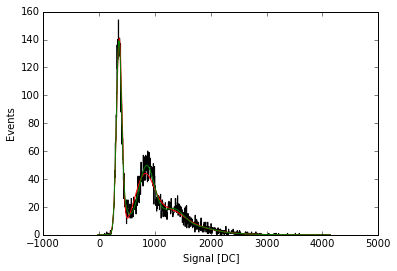

In [13]:
mes_hist_plot = calin.math.histogram.SimpleHist(5.0)
mes_hist_plot.insert_vec(fernandez_data);

ihist = range(1,mes_hist_plot.nbin()-2);
xhist = list(map(lambda i: mes_hist_plot.xval_center(i),ihist))
yhist = list(map(lambda i: mes_hist_plot.weight(i),ihist))
step(xhist,yhist,'k')
xlabel('Signal [DC]')
ylabel('Events')
mes_model_gauss.set_parameter_values(xopt_gauss)
ymodel_gauss = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_gauss.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_gauss,'r')

mes_model_two_cpt.set_parameter_values(xopt_two_cpt)
ymodel_two_cpt = \
    list(map(lambda x: mes_hist_plot.sum_w()*mes_hist_plot.dxval()*mes_model_two_cpt.pdf_mes(x),xhist))
hold('on')
plot(xhist,ymodel_two_cpt,'g')

gcf().savefig('spe_two_cpt.pdf')